Fitting a WL mass using `clmm`

_the LSST-DESC CLMM team_

In [1]:
from astropy.cosmology import FlatLambdaCDM
import clmm
import sys
# This notebook must be run from the  
sys.path.append('./support')
import mock_data as mock
import numpy as np
from numpy import random
from scipy import optimize as spo
from clmm import modeling as mod

In [2]:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

import numpy as np
import cluster_toolkit as ct
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

from astropy import constants, cosmology, units

Ncm.cfg_init ()

In [3]:
# define a true cosmology
# NB: need to cclify the astropy cosmology for generating the mock data (depends on modeling.py). 
# However, this is the astropy cosmology object that will need to be used on the data side, 
# profileaveraging.py (data side)

mock_cosmo = FlatLambdaCDM(H0=70, Om0=0.27, Ob0=0.045)
# cclify allows access to the cosmo parameter the CCL way, but it is NOT a CCL cosmology object,
# but simply a dictionary
mock_cosmo_ccl = clmm.cclify_astropy_cosmo(mock_cosmo) 

In [4]:
class NumCosmoModeling:
    def __init__ (self, cosmo_ccl, z_max = 3.0, Delta = 200.0, c = 4.0, Mass = 1.0e13):
        cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDEXcdm")
        cosmo.omega_x2omega_k ()

        cosmo.props.w       = -1.0
        cosmo.props.H0 = cosmo_ccl['H0']

        cosmo.param_set_by_name ("H0",     cosmo_ccl['H0'])
        cosmo.param_set_by_name ("Omegab", cosmo_ccl['Omega_b'])
        cosmo.param_set_by_name ("Omegac", cosmo_ccl['Omega_c'])
        cosmo.param_set_by_name ("w",      -1.0)
        cosmo.param_set_by_name ("Omegak",  0.0)
        cosmo.param_set_by_name ("Tgamma0", 0.0)
        
        dp              = Nc.DensityProfileNFW.new (Nc.DensityProfileMassDef.MEAN, Delta)
        dp.props.MDelta = Mass
        dp.props.c      = c
        
        dist = Nc.Distance.new (z_max)
        
        smd  = Nc.WLSurfaceMassDensity.new (dist)
        smd.prepare (cosmo)

        self.dp = dp
        self.cosmo = cosmo
        self.dist = dist
        self.smd = smd

def nc_get_angular_diameter_distance_a (nc, aexp2, aexp1=1.0):
    if aexp1 == 1.0:
        Da = nc.dist.angular_diameter (nc.cosmo, 1.0 / aexp2 - 1.0) 
    else:
        Da = (nc.dist.transverse (nc.cosmo, 1.0 / aexp2 - 1.0) - nc.dist.transverse (nc.cosmo, 1.0 / aexp1 - 1.0)) * aexp2
    return Da * nc.cosmo.RH_Mpc () * 1.0e6

def nc_predict_reduced_tangential_shear(r_proj, mdelta, cdelta, z_cluster, z_source, cosmo, Delta=200,
                                        halo_profile_parameterization='nfw', z_src_model='single_plane'):
    nc = cosmo
    nc.dp.props.c      = cdelta
    nc.dp.props.MDelta = mdelta
    
    try:
        args = [(r_i / nc.cosmo.h (), z_i, z_cluster, z_cluster) for r_i, z_i in zip (r_proj, z_source)]
    except:
        args = [(r_i / nc.cosmo.h (), z_source, z_cluster, z_cluster) for r_i in r_proj]
    return np.array ([nc.smd.reduced_shear(nc.dp, nc.cosmo, *arg) for arg in args])

    
clmm.get_angular_diameter_distance_a = nc_get_angular_diameter_distance_a
mod.get_angular_diameter_distance_a  = nc_get_angular_diameter_distance_a

clmm.predict_reduced_tangential_shear = nc_predict_reduced_tangential_shear
mod.predict_reduced_tangential_shear  = nc_predict_reduced_tangential_shear


In [5]:


nc_cosmo = NumCosmoModeling (mock_cosmo_ccl)

# Make mock data

In [6]:
# define toy cluster parameters

config = {}
config['cosmo'] = nc_cosmo
config['cluster_id'] = "Awesome_cluster"
config['cluster_m'] = 1.e15
config['cluster_z'] = 0.3
config['src_z'] = 0.8
config['concentration'] = 4
config['ngals'] = 10000
config['Delta'] = 200

In [7]:
# make mock data object

ideal_data = mock.MockData(config=config)

In [8]:
# populate catalog of galaxy cluster

ideal_data.generate() # single source plane, no shape noise, no redshift error

In [9]:
# make a clmm.GalaxyCluster object
# NB: mock data puts galaxy clusters in (0,0)
cluster_ra = 0.0
cluster_dec = 0.0
gc_object = clmm.GalaxyCluster(config['cluster_id'], cluster_ra, cluster_dec, 
                               config['cluster_z'], ideal_data.catalog)

In [10]:
# save the clmm.GalaxyCluster object

gc_object.save('mock_GC.pkl')

# Derive observables

In [11]:
# load a clmm.GalaxyCluster object

cl = clmm.load_cluster('mock_GC.pkl')

ra_l = cl.ra
dec_l = cl.dec
z = cl.z
e1 = cl.galcat['e1']
e2 = cl.galcat['e2']
ra_s = cl.galcat['ra']
dec_s = cl.galcat['dec']

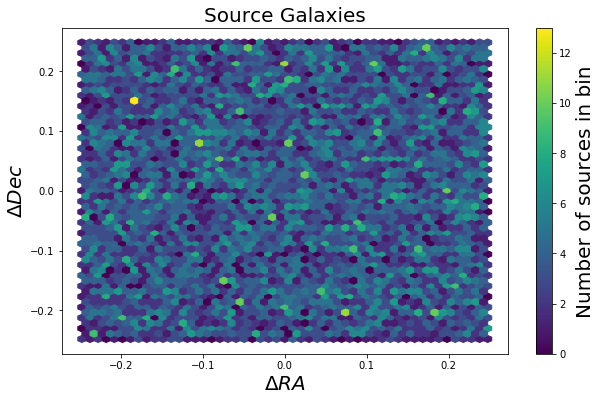

In [12]:
import matplotlib.pyplot as plt
#%matplotlib inline

fsize = 20

fig = plt.figure(figsize=(10,6))
hb = fig.gca().hexbin(ra_s, dec_s, gridsize=50)

cb = fig.colorbar(hb)
cb.set_label('Number of sources in bin', fontsize=fsize)

plt.gca().set_xlabel(r'$\Delta RA$', fontsize=fsize)
plt.gca().set_ylabel(r'$\Delta Dec$', fontsize=fsize)
plt.gca().set_title('Source Galaxies', fontsize=fsize)

plt.show()

### Tangential shear, cross shear for each source galaxy in the cluster

In [13]:
(theta, g_t, g_x) = cl.compute_shear()

Text(0.5, 0, 'angular distance [deg?]')

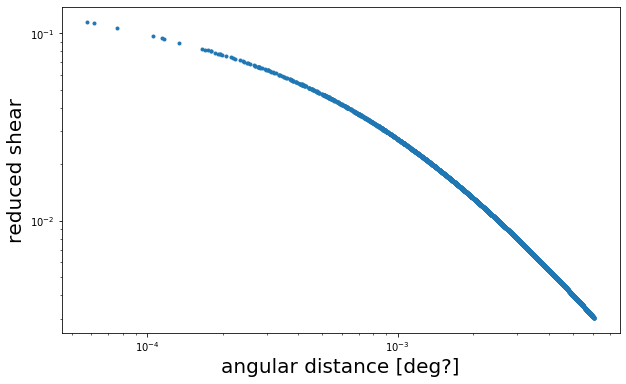

In [14]:
fig = plt.figure(figsize=(10,6))

fig.gca().loglog(theta, g_t, '.')
plt.ylabel("reduced shear", fontsize=fsize)
plt.xlabel("angular distance [deg?]", fontsize=fsize)

### Make the binned profile

Using 2 different binnings to highlight the impact on the reconstructed mass when doing naive fitting (not accounting for the binning in the model estimation)

In [15]:
# define bins
bin_edges1 = clmm.make_bins(0.01, 3.7, 50)
bin_edges2 = clmm.make_bins(0.01, 3.7, 10)

Text(0, 0.5, '$g_t$')

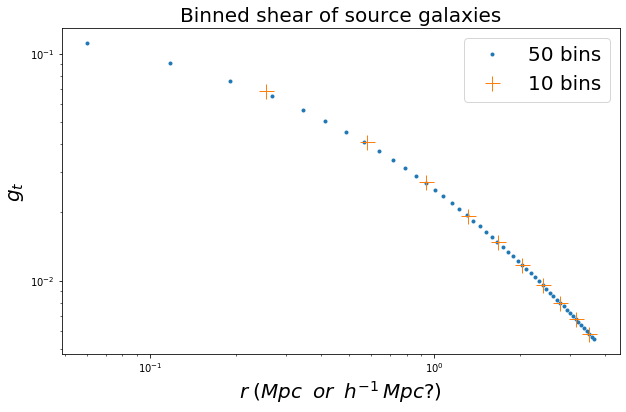

In [16]:
fig = plt.figure(figsize=(10,6))

res1 = cl.make_shear_profile("Mpc", cosmo=mock_cosmo, cosmo_object_type='astropy', 
                             bins=bin_edges1)
res2 = cl.make_shear_profile("Mpc", cosmo=mock_cosmo, cosmo_object_type='astropy', 
                             bins=bin_edges2)

fig.gca().loglog(res1['radius'], res1['gt'], '.', label='50 bins')
fig.gca().loglog(res2['radius'], res2['gt'], '+', markersize=15, label='10 bins')
plt.legend(fontsize=fsize)
gt_profile1 = res1['gt']
r1 = res1['radius']

gt_profile2 = res2['gt']
r2 = res2['radius']

plt.gca().set_title(r'Binned shear of source galaxies', fontsize=fsize)
plt.gca().set_xlabel(r'$r\;(Mpc\;\;or\;\;h^{-1}\,Mpc?)$', fontsize=fsize)
plt.gca().set_ylabel(r'$g_t$', fontsize=fsize)

# Construct model

Simply estimating the model at the bin location. In that case, the mass reconstruction is dependent on the binning. Future developement would be to take the average of the model inside the bin instead, which should solve this issue for this set of ideal data.

In [17]:
# select density profile parametrization and parameter values
def nfw_to_shear_profile1(logm):
    m = 10.**logm
    gt_model = clmm.predict_reduced_tangential_shear(r1, m, config['concentration'], config['cluster_z'], 
                                                    config['src_z'], config['cosmo'], 
                                        Delta=200, halo_profile_parameterization='nfw')
    return sum((gt_model - gt_profile1) **2)

def nfw_to_shear_profile2(logm):
    m = 10.**logm
    gt_model = clmm.predict_reduced_tangential_shear(r2, m, config['concentration'], config['cluster_z'], 
                                                    config['src_z'], config['cosmo'], 
                                        Delta=200, halo_profile_parameterization='nfw')
    return sum((gt_model - gt_profile2) **2)

# Fit for mass

In [18]:
# optimize to find the best-fit mass

logm_0 = random.uniform(13., 17., 1)[0]
logm_est1 = spo.minimize(nfw_to_shear_profile1, logm_0).x
logm_est2 = spo.minimize(nfw_to_shear_profile2, logm_0).x
m_est1 = 10.**logm_est1
m_est2 = 10.**logm_est2

In [19]:
m_est1, m_est2

(array([1.00304258e+15]), array([1.03994821e+15]))

In [20]:
import numpy as np
rr = np.logspace(-2,np.log10(5),100)
gt_model1 = clmm.predict_reduced_tangential_shear(rr, m_est1, config['concentration'], config['cluster_z'], 
                                                    config['src_z'], config['cosmo'], 
                                        Delta=200, halo_profile_parameterization='nfw')

gt_model2 = clmm.predict_reduced_tangential_shear(rr, m_est2, config['concentration'], config['cluster_z'], 
                                                    config['src_z'], config['cosmo'], 
                                        Delta=200, halo_profile_parameterization='nfw')

Text(0, 0.5, 'reduced tangential shear')

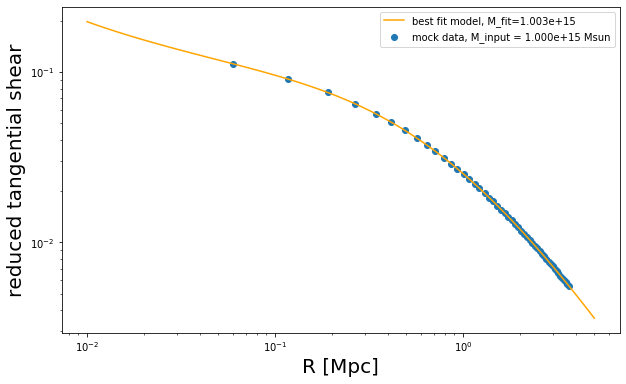

In [21]:
fig = plt.figure(figsize=(10,6))

fig.gca().scatter(r1, gt_profile1, label='mock data, M_input = %.3e Msun'%config['cluster_m'])
fig.gca().plot(rr, gt_model1, label = 'best fit model, M_fit=%.3e'%m_est1, color='orange')
plt.semilogx()
plt.semilogy()

plt.legend()
plt.xlabel('R [Mpc]', fontsize=fsize)
plt.ylabel('reduced tangential shear', fontsize=fsize)

Text(0, 0.5, 'reduced tangential shear')

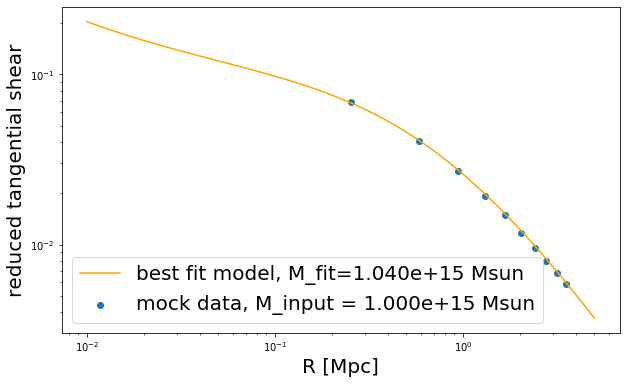

In [22]:
fig = plt.figure(figsize=(10,6))

fig.gca().scatter(r2, gt_profile2, label='mock data, M_input = %.3e Msun'%config['cluster_m'])
fig.gca().plot(rr, gt_model2, label = 'best fit model, M_fit=%.3e Msun'%m_est2, color='orange')
plt.semilogx()
plt.semilogy()

plt.legend(fontsize=fsize)
plt.xlabel('R [Mpc]', fontsize=fsize)
plt.ylabel('reduced tangential shear', fontsize=fsize)